https://www.kaggle.com/datasets/aashita/nyt-comments

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


입력받은 단어를 이용해서 문장을 완성

LSTM

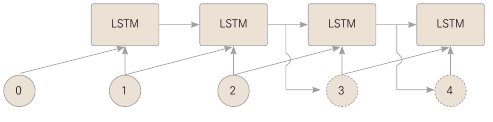

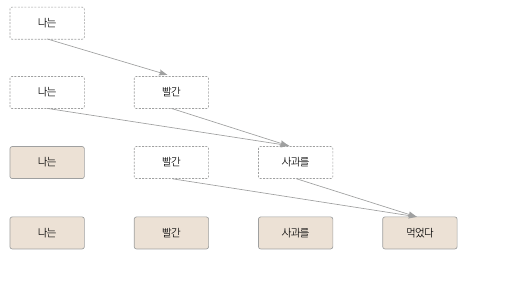

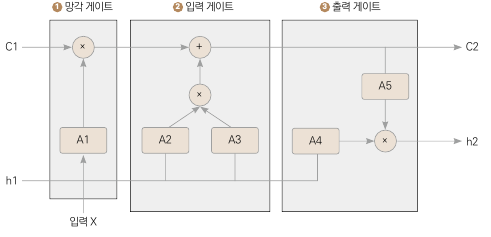

- 망각 게이트
  - 셀 상태에 저장된 과거의 정보를 사용할 것인지에 대한 여부를 결정
- 입력 게이트
  - 셀 상태에 현재 정보를 덮어쓸 것인지를 결정
- 출력 게이트  
  - 셀 상태와 현재 정보를 합쳐 현재의 은닉상태를 결정

In [2]:
!unzip /content/drive/MyDrive/NYT_COMMENTS.zip -d ./NYT

Archive:  /content/drive/MyDrive/NYT_COMMENTS.zip
  inflating: ./NYT/ArticlesApril2017.csv  
  inflating: ./NYT/ArticlesApril2018.csv  
  inflating: ./NYT/ArticlesFeb2017.csv  
  inflating: ./NYT/ArticlesFeb2018.csv  
  inflating: ./NYT/ArticlesJan2017.csv  
  inflating: ./NYT/ArticlesJan2018.csv  
  inflating: ./NYT/ArticlesMarch2017.csv  
  inflating: ./NYT/ArticlesMarch2018.csv  
  inflating: ./NYT/ArticlesMay2017.csv  
  inflating: ./NYT/CommentsApril2017.csv  
  inflating: ./NYT/CommentsApril2018.csv  
  inflating: ./NYT/CommentsFeb2017.csv  
  inflating: ./NYT/CommentsFeb2018.csv  
  inflating: ./NYT/CommentsJan2017.csv  
  inflating: ./NYT/CommentsJan2018.csv  
  inflating: ./NYT/CommentsMarch2017.csv  
  inflating: ./NYT/CommentsMarch2018.csv  
  inflating: ./NYT/CommentsMay2017.csv  


In [3]:
import pandas as pd
df = pd.read_csv('/content/NYT/ArticlesApril2017.csv')
df.headline

0      Finding an Expansive View  of a Forgotten Peop...
1                      And Now,  the Dreaded Trump Curse
2                  Venezuela’s Descent Into Dictatorship
3                  Stain Permeates Basketball Blue Blood
4                              Taking Things for Granted
                             ...                        
881                  Reporting on Gays Who ‘Don’t Exist’
882    The Fights That Could Lead to a Government Shu...
883    ‘The Leftovers’ Season 3, Episode 2: Swedish P...
884                          Thinking Out Loud, But Why?
885                    Some Sugar. Could Use More Spice.
Name: headline, Length: 886, dtype: object

학습용데이터
  - 구두점과 특수문자를 제거
  - 딥러닝이 단어를 이해할수 있도록 사전을만듦, 고유번호를 부여
  - BOW(Bag of Words)

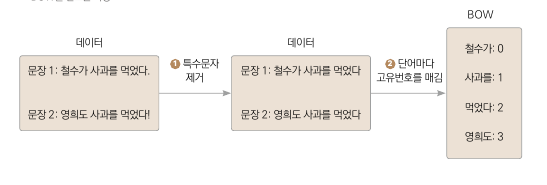

In [4]:
import glob
from torch.utils.data.dataset import Dataset
import string
import numpy as np

In [5]:
class TextGeneration(Dataset):
  def clean_text(self,text):
    # 모든 단어를 소문자로 변경하고 특수문자를 제거
    txt = "".join(t for t in text if t not in string.punctuation).lower()
    return txt
  def __init__(self):
    all_headlines = []
    # 모든 헤드라인을 불러옮
    for filename in glob.glob("./NYT/Articles*.csv"):
      article_df = pd.read_csv(filename)
      all_headlines.extend(list(article_df.headline.values))

    # headline중에 unknown값 제거
    all_headlines = [title for title in all_headlines if title != 'Unknown']
    # 구두점 제거 및 전처리가 된 문장을 리스트로 반환
    self.corpus = [self.clean_text(x) for x in all_headlines]
    self.BOW = {}
    # 모든 문장의 단어를 추출해서 고유 번호 지정
    for line in self.corpus:
      for word in line.split():
        if word not in self.BOW.keys():
          self.BOW[word] = len(self.BOW.keys())
    # 모델의 입력으로 사용할 데이터
    self.data = self.generate_sequence(self.corpus)
  def generate_sequence(self,txt):
    seq = []
    for line in txt:
      line = line.split()
      line_bow = [ self.BOW[word] for word in line]
      # 단어 2개를 입력으로, 그 다음 단어를 정답

      data = [([line_bow[i], line_bow[i+1]], line_bow[i+2])  for i in range(len(line_bow)-2)]
      seq.extend(data)
    return seq

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    data = np.array(self.data[index][0])
    label = np.array(self.data[index][1]).astype(np.float32)
    return data, label

In [6]:
all_headlines = []
# 모든 헤드라인을 불러옮
for filename in glob.glob("./NYT/Articles*.csv"):
  article_df = pd.read_csv(filename)
  all_headlines.extend(list(article_df.headline.values))

In [7]:
# unknow 값 제거
all_headlines = [title for title in all_headlines if title != 'Unknown']

In [8]:
# 구두점 제거 및 전처리가 된 문장을 리스트로 반환
def clean_text(text):
    # 모든 단어를 소문자로 변경하고 특수문자를 제거
    txt = "".join(t for t in text if t not in string.punctuation).lower()
    return txt
corpus = [clean_text(x) for x in all_headlines]
BOW = {}

In [9]:
# 모든 문장의 단어를 추출해서 고유 번호 지정
for line in corpus:
  for word in line.split():
    if word not in BOW.keys():
      BOW[word] = len(BOW.keys())

In [10]:
BOW

{'virtual': 0,
 'coins': 1,
 'real': 2,
 'resources': 3,
 'us': 4,
 'advances': 5,
 'military': 6,
 'plans': 7,
 'for': 8,
 'north': 9,
 'korea': 10,
 'mr': 11,
 'trump': 12,
 'and': 13,
 'the': 14,
 '‘very': 15,
 'bad': 16,
 'judge’': 17,
 'to': 18,
 'erase': 19,
 'dissent': 20,
 'china': 21,
 'bans': 22,
 'pooh': 23,
 'bear': 24,
 '‘n’': 25,
 'loans': 26,
 'flowed': 27,
 'kushner': 28,
 'cos': 29,
 'after': 30,
 'visits': 31,
 'white': 32,
 'house': 33,
 'envoy': 34,
 'intends': 35,
 'ease': 36,
 'trade': 37,
 'tensions': 38,
 'president': 39,
 'trump’s': 40,
 'contradictory': 41,
 'sometimes': 42,
 'false': 43,
 'comments': 44,
 'about': 45,
 'gun': 46,
 'policy': 47,
 'lawmakers': 48,
 'classic': 49,
 'letter': 50,
 'puzzle': 51,
 'silicon': 52,
 'valley': 53,
 'disruption': 54,
 'in': 55,
 'an': 56,
 'australian': 57,
 'school': 58,
 '‘the': 59,
 'assassination': 60,
 'of': 61,
 'gianni': 62,
 'versace’': 63,
 'episode': 64,
 '6': 65,
 'a': 66,
 'nothing': 67,
 'man': 68,
 'gradua

모델 정의
  - 희소표현
    - 벡터의 요소의 대부분이 0인 표현 방법

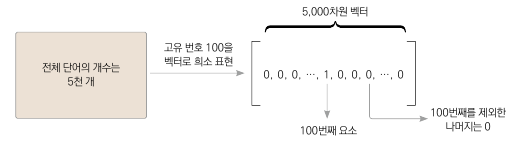

대부분의 값이 0인 벡터에 어떤 값을 더해도 0이되고.... 그래서 학습이 제대로 안됨...
  - 임베딩 필요
    - 희소표현을 밀집표현으로 바꿔주는 층
    - 밀집표현 : 0이 거의 포함되어 있는 않는 표현방법

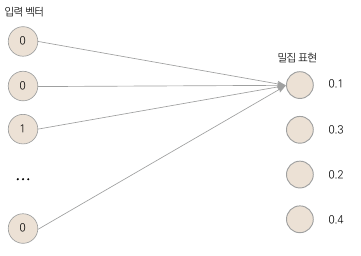

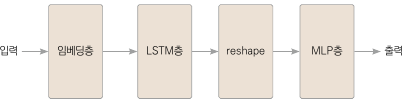

In [11]:
# 밀집표현은 파이토치의 임베디드층이 계산

In [12]:
import torch.nn as nn

In [13]:
import torch
class LSTM(nn.Module):
  def __init__(self, num_embeddings):
    super(LSTM,self).__init__()
    self.embed = nn.Embedding(num_embeddings=num_embeddings,embedding_dim=16)
    self.lstm = nn.LSTM(
        input_size = 16,
        hidden_size = 64,
        num_layers = 5,
        batch_first = True
        )
    self.fc1 = nn.Linear(128,num_embeddings)
    self.fc2 = nn.Linear(num_embeddings,num_embeddings)
    self.relu = nn.ReLU()
  def forward(self,x):
    x = self.embed(x)

    # lstm모델의 예측값
    x,_ =self.lstm(x)
    x = torch.reshape(x, (x.shape[0],-1))
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    return x

학습

In [14]:
import tqdm
import torch
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset = TextGeneration()
model = LSTM(num_embeddings=len(dataset.BOW)).to(device)
loader = DataLoader(dataset, batch_size=64)
optim = Adam(model.parameters(), lr=1e-3)

for epoch in range(200):
  iterdata = tqdm.tqdm(loader)
  for data, label in iterdata:
    #기울기 초기화
    optim.zero_grad()
    pred = model(torch.tensor(data,dtype=torch.long).to(device))
    #정답은 long텐서로 변환
    loss = nn.CrossEntropyLoss()(pred,torch.tensor(label,dtype=torch.long).to(device))
    # 역전파
    loss.backward()
    optim.step()
    iterdata.set_description(f"epoch:{epoch} loss:{loss.item()}")
torch.save(model.state_dict(),"lstm.pth")

  0%|          | 0/677 [00:00<?, ?it/s]<ipython-input-14-dd2d11228d43>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(data,dtype=torch.long).to(device))
<ipython-input-14-dd2d11228d43>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = nn.CrossEntropyLoss()(pred,torch.tensor(label,dtype=torch.long).to(device))
epoch:19 loss:5.585506916046143: 100%|██████████| 677/677 [00:11<00:00, 58.32it/s]


모델성능 평가
  - 반복적으로 모델을 사용

In [21]:
def generate(model, BOW, string = "the fights ",strlen = 10):
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(f"input word:{string}")
  with torch.no_grad():
    for p in range(strlen):
      # 입력문장을 텐서로 변경
      words = torch.tensor(
          [BOW[w] for w in string.split()],dtype = torch.long
      ).to(device)
      # 모델의 입력으로 사용하기 위한 배치 차원 추가
      input_tensor = torch.unsqueeze(words[-2:],dim=0)
      output = model(input_tensor)
      output_word = (torch.argmax(output).cpu().numpy())
      string += list(BOW.keys())[output_word] # 문장에 예측된 단어를 추가
      string += " "

    print(f"predicted sentence : {string}")
model.load_state_dict(torch.load('lstm.pth',map_location=device))
pred = generate(model,dataset.BOW)


input word:the fights 
predicted sentence : the fights of the new york of the new york of the 
